# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [818]:
#Imports 
import json
import requests
import pandas as pd
from tqdm import tqdm
import numpy as np
import pprint as pp
from scipy import stats





In [819]:

urls = []
urls.append('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv')
urls.append('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')



2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [820]:
for url in urls:    
    r = requests.get(url) 
    fn_idx = len(url) - url[::-1].find('/')    
    with open(url[fn_idx:],'wb') as file:
        file.write(r.content)

In [821]:
#import both files into dataframes

df_image_predict = pd.read_csv('image-predictions.tsv',sep='\t')
df_archive_en = pd.read_csv('twitter-archive-enhanced.csv')


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [822]:
#Read keys and tokens from config.yaml:
import yaml
with open(r'config.yaml') as file:
    config = yaml.full_load(file)

consumer_key = config['consumer_key']
consumer_secret = config['consumer_secret']

  

In [823]:
#create tweetpy instance
import tweepy

access_secret = ''
access_token = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
print(access_secret, access_token)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


The two existing datasets do not have the same number of tweet IDs.
Check to see if the shorter series of IDs (df_image_predict[tweet_id']) is a subset of the longer (df_archive_en['tweet_id'])  

In [824]:
assert set(df_image_predict.tweet_id).issubset(set(df_archive_en.tweet_id))
df_archive_en.tweet_id.shape[0] - df_image_predict.tweet_id.shape[0]

281

In [825]:
#download and store the tweets

json_dicts = []
icount = 0
tweep_errs = {}
# for _ in tqdm(df_archive_en.tweet_id, desc="Retrieving tweets...", file=sys.stdout):
#     icount += 1    
#     try:
#         json_dicts.append(dict(api.get_status(_)._json))
#     except tweepy.TweepError as e:  
#         err = e.args[0][0] 
#         tweep_errs[_] = err
# #    if (icount == 100): break

# with open(r'tweet_json.txt','w') as file:
#      file.writelines(json.dumps(json_dicts))

#api.get_status('837366284874571778')._json
api.get_status('891689557279858688')._json



{'created_at': 'Sun Jul 30 15:58:51 +0000 2017',
 'id': 891689557279858688,
 'id_str': '891689557279858688',
 'text': 'This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 891689552724799489,
    'id_str': '891689552724799489',
    'indices': [80, 103],
    'media_url': 'http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg',
    'url': 'https://t.co/tD36da7qLQ',
    'display_url': 'pic.twitter.com/tD36da7qLQ',
    'expanded_url': 'https://twitter.com/dog_rates/status/891689557279858688/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 510, 'h': 680, 'resize': 'fit'},
     'medium': {'w': 901, 'h': 1200, 'resize': 'fit'},
     'large': {'w': 1201, 'h': 1600, 'resize': 'fit'}}}]},
 'e

In [826]:
#Check to see what kinds of errors we got... 
# df_errs = pd.DataFrame(tweep_errs).transpose()
# df_errs.message.value_counts()


In [827]:
#Read the stored tweets from file and put them in a dataframe with variables 'id', 'retweet_count', 'favorite_count'

json_list = []
df_tweet_json = pd.read_json('tweet_json.txt')
df_tweet_json.columns
df_tweet_json = df_tweet_json[['id', 'retweet_count', 'favorite_count']]
df_tweet_json.sample(25)

,id,retweet_count,favorite_count
1369,699779630832685056,1128,2540
440,817908911860748288,750,4650
932,751205363882532864,1688,5966
862,759846353224826880,1826,6354
1769,677228873407442944,1481,3243
2013,671538301157904385,340,843
2258,667177989038297088,49,169
1985,672222792075620352,178,712
53,881666595344535552,9049,45024
1708,679530280114372609,1909,4423


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Accessing df_archive_en (of provided dataset twitter-archive-enhanced.csv):

In [828]:
df_archive_en.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
306,836001077879255040,NaN,NaN,2017-02-26 23:52:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Atlas is back and this time he's prettier than...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/836001077...,13,10,None,None,None,None,None
636,793500921481273345,NaN,NaN,2016-11-01 17:12:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fiona. She's an extremely mediocre cop...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793500921...,12,10,Fiona,None,None,None,None
274,840698636975636481,8.406983e+17,8.405479e+17,2017-03-11 22:59:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@0_kelvin_0 &gt;10/10 is reserved for puppos s...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1504,691820333922455552,NaN,NaN,2016-01-26 03:09:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Brockly. He's an uber driver. Falls as...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691820333...,8,10,Brockly,None,None,None,None
988,748977405889503236,NaN,NaN,2016-07-01 20:31:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What jokester sent in a pic without a dog in i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748977405...,10,10,not,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Not familiar with this breed. No tail (weird)....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
443,819347104292290561,NaN,NaN,2017-01-12 00:55:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Anna and Elsa. They fall asleep i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819347104...,12,10,Anna,None,None,None,None
2031,671768281401958400,NaN,NaN,2015-12-01 19:10:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you try to recreate the scene from Lady &...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671768281...,10,10,None,None,None,None,None
1579,687312378585812992,NaN,NaN,2016-01-13 16:36:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""You got any games on your phone"" 7/10 for inv...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/687312378...,7,10,None,None,None,pupper,None


In [829]:
df_archive_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [830]:
#Check for duplicates
df_archive_en.drop(columns=['timestamp']).duplicated().sum()

0

In [831]:
#Investigating the meaning of retweeted_ids
retweeted_ids = df_archive_en.retweeted_status_id.apply(lambda _: format(_, '.0f'))
(retweeted_ids != 'nan').sum()



181

In [832]:
#Look for tweets with missing ratings
display(df_archive_en.rating_numerator.sort_values())
display(df_archive_en.rating_denominator.sort_values())


315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [833]:
#checking the meaning of user retweeted id
#comparing IDs here https://tweeterid.com/ 
retweeted_user_ids = df_archive_en.retweeted_status_user_id.apply(lambda _: format(_, '.0f'))
retweeted_user_ids[(retweeted_user_ids != 'nan')].value_counts()

4196983835            156
4296831739              2
512804507               1
712457247234756608      1
783214                  1
280479778               1
195036846               1
1732729088              1
1228325660              1
79923701                1
24885566                1
487197737               1
44667502                1
726634734               1
154767397               1
19607400                1
41198418                1
597064155               1
341021133               1
747554344434831360      1
66699013                1
58709723                1
363890752               1
787461778435289088      1
811740824               1
Name: retweeted_status_user_id, dtype: int64

In [834]:
#checking the consistency of the rating system...
df_archive_en[['rating_numerator', 'rating_denominator']].value_counts()

rating_numerator  rating_denominator
12                10                    558
11                10                    463
10                10                    461
13                10                    351
9                 10                    156
8                 10                    102
7                 10                     54
14                10                     54
5                 10                     37
6                 10                     32
3                 10                     19
4                 10                     15
2                 10                      9
1                 10                      8
420               10                      2
15                10                      2
0                 10                      2
9                 11                      2
4                 20                      2
75                10                      2
666               10                      1
84                70                   

In [835]:
### Accessing df_image_predict:

In [836]:
df_image_predict.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1839,837482249356513284,https://pbs.twimg.com/media/C59VqMUXEAAzldG.jpg,2,birdhouse,0.541196,False,can_opener,0.121094,False,carton,0.056137,False
803,691483041324204033,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,1,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True
691,684200372118904832,https://pbs.twimg.com/media/CX7EkuHWkAESLZk.jpg,1,llama,0.681347,False,ram,0.120142,False,hog,0.043686,False
1137,728986383096946689,https://pbs.twimg.com/media/Ch3hOGWUYAE7w0y.jpg,2,Maltese_dog,0.952070,True,toy_poodle,0.027271,True,miniature_poodle,0.004874,True
1493,783085703974514689,https://pbs.twimg.com/media/Ct4URfWUAAQ7lKe.jpg,1,Chesapeake_Bay_retriever,0.240602,True,Airedale,0.164088,True,boxer,0.134506,True
1100,720775346191278080,https://pbs.twimg.com/media/CgC1WqMW4AI1_N0.jpg,1,Newfoundland,0.489970,True,groenendael,0.174497,True,giant_schnauzer,0.079067,True
1775,828372645993398273,https://pbs.twimg.com/media/C374hb0WQAAIbQ-.jpg,1,malamute,0.663047,True,Eskimo_dog,0.207779,True,Tibetan_mastiff,0.040949,True
665,682750546109968385,https://pbs.twimg.com/media/CXmd_bsWkAEEXck.jpg,1,English_setter,0.947198,True,English_springer,0.031128,True,Brittany_spaniel,0.005512,True
317,671744970634719232,https://pbs.twimg.com/media/CVKEfMKWoAAR-Ud.jpg,1,ice_bear,0.251193,False,ram,0.213839,False,Arctic_fox,0.081551,False
2018,880221127280381952,https://pbs.twimg.com/media/DDcscbXU0AIfDzs.jpg,1,Chihuahua,0.238525,True,meerkat,0.104256,False,clumber,0.052580,True


In [837]:
#Identify duplicate images
df_image_predict.drop(columns='tweet_id').duplicated().sum()


66

In [838]:
#Look for images that have a high probability of containing no dog
df_image_predict_not_dogs = df_image_predict.query('p1_dog == p2_dog == p3_dog == False')
display(df_image_predict_not_dogs.sample(15))
print(f"Not dog count: {df_image_predict_not_dogs.shape[0]}")


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False
1448,776113305656188928,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False
246,670474236058800128,https://pbs.twimg.com/media/CU4AwqQWUAAEgE2.jpg,1,wool,0.070076,False,siamang,0.062536,False,gorilla,0.058894,False
1751,824297048279236611,https://pbs.twimg.com/media/C3B9ypNWEAM1bVs.jpg,2,teddy,0.588230,False,jigsaw_puzzle,0.028910,False,doormat,0.022251,False
1611,801285448605831168,https://pbs.twimg.com/media/Cx683NPUAAAjyU4.jpg,1,minivan,0.789376,False,beach_wagon,0.081125,False,convertible,0.064534,False
448,674690135443775488,https://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg,1,tick,0.242538,False,nail,0.212589,False,screw,0.172838,False
199,669661792646373376,https://pbs.twimg.com/media/CUsd2TfWwAAmdjb.jpg,1,weasel,0.262802,False,Siamese_cat,0.148263,False,hamster,0.116374,False
2012,879050749262655488,https://pbs.twimg.com/media/DDMD_phXoAQ1qf0.jpg,1,tabby,0.311861,False,window_screen,0.169123,False,Egyptian_cat,0.132932,False
1414,771014301343748096,https://pbs.twimg.com/media/CrMxZzgWIAQUxzx.jpg,1,meerkat,0.202335,False,doormat,0.111790,False,macaque,0.088925,False
1605,800443802682937345,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False


Not dog count: 324


### Quality issues
1. retweeted_status_id's could be self-retweets. This means that any of these 181 records could represent duplicate data. It appears we may be able to identify 'self-retweets' by comparing retweeted_status_user_id

2. The rating scale appears to be inconsistent.

3. The rating scale appears as though it will likely have outliers that will need to be removed for analysis/visualization. Merge into one column as float.

4. There are 281 tweets in **twitter-archive-enhanced** that do not have corrosponding records in **image-predictions.tsv**

5. Some division by 0 in the denominators

6. **source** column should be parsed and categorized. It also requires a meaningful column name. 

7. Drop these columns as they are outside the scope of our analysis: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,  retweeted_status_timestamp, expanded_urls

8. Change the following to datatypes: tweet_id: string, timestamp: datetime, source: category, retweeted_status_id: string, retweeted_status_user_id: string, retweeted_status_timestamp: datetime


#### image-predictions
9. There appear to be 66 duplicate images/image predictions. Since image_predictions tweet IDs are a subset of twitter-archive-enhanced tweet IDs, the 66 duplicates in image-predictions will corrospond to tweets in the later set.

10. There are 324 records where no dogs were detected whatsoever.

11. Take the most likely of p1, p2, p3, move it to a new column predicted_breed and drop the others.



### Tidiness issues
#### df_archive_en / twitter-archive-enhanced
1. Merge doggo, floofer, pupper, puppo into one column of type category

2. Merge df_image_predict, df_tweet_json, and df_archive_en into one master clean dataframe

#### df_image_predict / image-predictions


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [839]:
# Make copies of original pieces of data

df_archive_clean = df_archive_en.copy()
df_predict_clean = df_image_predict.copy()

### Cleanliness Issue #1:
Columns need to be set to appropriate datatypes.

#### Define: 
Change the following to datatypes
- df_archive_clean:
    - tweet_id: string
    - timestamp: datetime
    - source: category
    - retweeted_status_id: string
    - retweeted_status_user_id: string
    - retweeted_status_timestamp: datetime 
- df_predict_clean:
    - tweet_id: string
- df_tweet_json
    - tweet_id: string
    - retweet_count: int
    - favorite_count: int


#### Code

In [840]:
df_archive_clean['tweet_id'] = df_archive_clean.tweet_id.astype(str)
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean.timestamp)
df_archive_clean['source'] = df_archive_clean.source.astype('category')
df_archive_clean['retweeted_status_id'] = df_archive_clean.retweeted_status_id.apply(lambda _: format(_, '.0f'))
df_archive_clean['retweeted_status_user_id'] = df_archive_clean.retweeted_status_user_id.apply(lambda _: format(_, '.0f'))
df_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(df_archive_clean.retweeted_status_timestamp)

In [841]:
df_predict_clean['tweet_id'] = df_predict_clean.tweet_id.astype(str)

In [842]:
df_tweet_json.rename(columns={'id': 'tweet_id'}, inplace=True)
df_tweet_json['tweet_id'] = df_tweet_json.tweet_id.astype(str)
df_tweet_json['favorite_count'] = df_tweet_json.favorite_count.astype('int64')
df_tweet_json['retweet_count'] = df_tweet_json.favorite_count.astype('int64')
#df_tweet_json.favorite_count.sort_values()

#### Test

In [843]:
display(df_archive_clean.info())
display(df_archive_clean.sample(10))
display(df_predict_clean.info())
display(df_predict_clean.sample(5))
display(df_tweet_json.info())
display(df_tweet_json.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   category           
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

None

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
317,834786237630337024,NaN,NaN,2017-02-23 15:25:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tobi. She is properly fetching her sho...,nan,nan,NaT,https://twitter.com/dog_rates/status/834786237...,13,10,Tobi,None,None,None,None
702,786036967502913536,NaN,NaN,2016-10-12 02:53:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Scout. He really wants ...,779834332596887552,4196983835,2016-09-25 00:06:08+00:00,https://twitter.com/dog_rates/status/779834332...,11,10,Scout,None,None,None,None
1770,678341075375947776,NaN,NaN,2015-12-19 22:28:09+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This pupper likes tape. 12/10 https://t.co/cSp...,nan,nan,NaT,https://twitter.com/dog_rates/status/678341075...,12,10,None,None,None,pupper,None
505,812781120811126785,NaN,NaN,2016-12-24 22:04:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Swagger. He's the Cleveland Browns amb...,nan,nan,NaT,https://twitter.com/dog_rates/status/812781120...,10,10,Swagger,None,None,None,None
711,784517518371221505,NaN,NaN,2016-10-07 22:15:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Frankie. He has yet to learn how to co...,nan,nan,NaT,https://twitter.com/dog_rates/status/784517518...,11,10,Frankie,None,None,None,None
384,826958653328592898,NaN,NaN,2017-02-02 01:01:21+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Loki. He smiles like Elvis. Ain't noth...,nan,nan,NaT,https://twitter.com/dog_rates/status/826958653...,12,10,Loki,doggo,None,None,None
203,853299958564483072,NaN,NaN,2017-04-15 17:32:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Rumpole. He'll be your Uber driver thi...,nan,nan,NaT,https://twitter.com/dog_rates/status/853299958...,13,10,Rumpole,None,None,None,None
1243,711968124745228288,NaN,NaN,2016-03-21 17:30:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's trapped in a cup of coffee....,nan,nan,NaT,https://twitter.com/dog_rates/status/711968124...,10,10,Winston,None,None,pupper,None
911,757597904299253760,NaN,NaN,2016-07-25 15:26:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @jon_hill987: @dog_rates There is a cunning...,757597141099548672,280479778,2016-07-25 15:23:28+00:00,https://twitter.com/jon_hill987/status/7575971...,11,10,None,None,None,pupper,None
88,875097192612077568,NaN,NaN,2017-06-14 21:06:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",You'll get your package when that precious man...,nan,nan,NaT,https://twitter.com/drboondoc/status/874413398...,13,10,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


None

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
173,669006782128353280,https://pbs.twimg.com/media/CUjKHs0WIAECWP3.jpg,1,Chihuahua,0.127178,True,Italian_greyhound,0.054215,True,pillow,0.048592,False
1932,859196978902773760,https://pbs.twimg.com/ext_tw_video_thumb/85919...,1,Angora,0.224218,False,malamute,0.216163,True,Persian_cat,0.128383,False
1988,872820683541237760,https://pbs.twimg.com/media/DBzhx0PWAAEhl0E.jpg,3,pug,0.999120,True,French_bulldog,0.000552,True,bull_mastiff,0.000073,True
190,669393256313184256,https://pbs.twimg.com/media/CUopnHPVEAAcL2o.jpg,1,cocker_spaniel,0.359843,True,Blenheim_spaniel,0.139519,True,toy_poodle,0.132746,True
344,672267570918129665,https://pbs.twimg.com/media/CVRfyZxWUAAFIQR.jpg,1,Irish_terrier,0.716932,True,miniature_pinscher,0.051234,True,Airedale,0.044381,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2327 non-null   object
 1   retweet_count   2327 non-null   int64 
 2   favorite_count  2327 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


None

,tweet_id,retweet_count,favorite_count
1223,710997087345876993,4268,4268
2132,669564461267722241,344,344
1853,674999807681908736,2018,2018
2191,668484198282485761,376,376
1169,717009362452090881,3016,3016


### Tidiness Issue #1: the 3 primary dataframes should be merged into a single dataframe; df_master

##### Define: Merge them on tweet ID. Will have to correct the name and datatype of df_tweet_json first in this step.

##### Code

In [844]:
df_master = pd.merge(df_archive_clean, df_predict_clean,how='inner', on='tweet_id')
df_master = df_master.merge(df_tweet_json, how="inner", on='tweet_id')
df_master.info()
# df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2057 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2057 non-null   datetime64[ns, UTC]
 4   source                      2057 non-null   category           
 5   text                        2057 non-null   object             
 6   retweeted_status_id         2057 non-null   object             
 7   retweeted_status_user_id    2057 non-null   object             
 8   retweeted_status_timestamp  71 non-null     datetime64[ns, UTC]
 9   expanded_urls               2057 non-null   object             
 10  rating_numerator            2057 non-null   int64           

##### Test

In [845]:
df_master.info()
assert df_master.columns.shape[0] == (df_archive_clean.columns.shape[0] + df_predict_clean.columns.shape[0] + df_tweet_json.columns.shape[0] - 2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2057 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2057 non-null   datetime64[ns, UTC]
 4   source                      2057 non-null   category           
 5   text                        2057 non-null   object             
 6   retweeted_status_id         2057 non-null   object             
 7   retweeted_status_user_id    2057 non-null   object             
 8   retweeted_status_timestamp  71 non-null     datetime64[ns, UTC]
 9   expanded_urls               2057 non-null   object             
 10  rating_numerator            2057 non-null   int64           

### Cleanliness Issue #2: retweeted_status_id's could be self-retweets. This means that any of these 181 records could represent duplicate data. It appears we may be able to identify 'self-retweets' by comparing retweeted_status_user_id

#### Define
Look for the retweet status ID in the tweet IDs. Drop the rows whos tweet IDs are in the retweet_status_ids list.

#### Code

In [846]:

df_size = df_master.shape[0]

retweet_status_ids = df_master[df_master.retweeted_status_id != 'nan'].retweeted_status_id

d_idx = df_master.query(f'tweet_id == {list(retweet_status_ids)}').index
df_master.drop(index=d_idx, inplace = True)
print(f"{df_size - df_master.shape[0]} rows dropped.")

45 rows dropped.


#### Test

In [847]:
assert df_master.query(f'tweet_id == {list(retweet_status_ids)}').shape[0] == 0



### Cleanliness Issue #3-4: The rating scale appears to be inconsistent. The rating scale appears as though it will likely have outliers that will need to be removed for analysis/visualization. Some division by 0 in the denominators


#### Define
Drop rows with a denominator of 0. Merge rating nominators/denonminators into a single column with a float value. Drop rows with missing ratings. Drop rows with significant outlier columns.

#### Code

In [848]:
#Drop rows with division by zero
df_size = df_master.shape[0]
df_master.drop(df_archive_clean[df_archive_clean['rating_denominator']==0].index, inplace=True)
print(f"{df_size - df_master.shape[0]} rows dropped.")

1 rows dropped.


In [849]:
#Create a new column to represent the fractional values, drop the old
df_master['rating'] = df_master.rating_numerator / df_master.rating_denominator


In [850]:
#Drop the columns that we've just replaced
df_master.drop(columns=['rating_numerator', 'rating_denominator'], inplace=True)


In [851]:
#identify and drop outliers - we will drop items that have ratings 2x outside the standard deviation
df_size = df_master.shape[0]
stat_outliers = df_master[(abs(stats.zscore(df_master.rating)) > 1)]
df_master.drop(stat_outliers.index, inplace=True)
print(f"{df_size - df_master.shape[0]} rows dropped.")

3 rows dropped.


#### Test

In [852]:
display(list(df_master.columns))
df_master.rating.sort_values()

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'retweet_count',
 'favorite_count',
 'rating']

240     0.000000
817     0.000000
1796    0.100000
2039    0.100000
1580    0.100000
          ...   
421     1.400000
222     1.500000
1436    2.600000
602     2.700000
405     3.428571
Name: rating, Length: 2008, dtype: float64

### Cleanliness Issue #5: There are tweets in **twitter-archive-enhanced** that do not have corrosponding records in **image-predictions.tsv** and vice versa

#### Define
We can identify these records by finding which tweets do not have a value for 'jpg_url'. These rows we will drop.

#### Code

In [853]:
#Determine which tweets we will drop
d_tweets = list(df_master.query('jpg_url != jpg_url').tweet_id)


In [854]:

#Drop them and confirm the number of rows dropped.
df_size = df_archive_clean.shape[0]
df_master.drop(df_master.query(f'tweet_id in {d_tweets}').index, inplace=True)
print(f"Dropped {df_size - df_master.shape[0]} records from df_archive_clean.")





Dropped 348 records from df_archive_clean.


#### Test


In [855]:
df_master.sample(25)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,rating
87,872122724285648897,NaN,NaN,2017-06-06 16:07:15+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kody. He's a baller. Wishes he was a l...,nan,nan,NaT,https://twitter.com/dog_rates/status/872122724...,...,False,pug,0.066736,True,dalmatian,0.054570,True,30549,30549,1.2
1580,675153376133427200,NaN,NaN,2015-12-11 03:21:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",What kind of person sends in a picture without...,nan,nan,NaT,https://twitter.com/dog_rates/status/675153376...,...,False,mailbox,0.096027,False,seat_belt,0.034995,False,5665,5665,0.1
390,813127251579564032,NaN,NaN,2016-12-25 21:00:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's an anonymous doggo that appears to be v...,nan,nan,NaT,https://twitter.com/dog_rates/status/813127251...,...,True,whippet,0.374223,True,Siberian_husky,0.032463,True,11321,11321,1.1
601,778039087836069888,NaN,NaN,2016-09-20 01:12:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Evolution of a pupper yawn featuring Max. 12/1...,nan,nan,NaT,https://twitter.com/dog_rates/status/778039087...,...,True,malinois,0.111175,True,Norwegian_elkhound,0.058802,True,8064,8064,1.2
1888,668988183816871936,NaN,NaN,2015-11-24 03:03:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Honor to rate this dog. Lots of fur on him. Tw...,nan,nan,NaT,https://twitter.com/dog_rates/status/668988183...,...,False,bison,0.000228,False,llama,0.000067,False,810,810,0.7
398,812503143955202048,NaN,NaN,2016-12-24 03:40:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I'm happy to inform you all that Jake is in ex...,nan,nan,NaT,https://m.facebook.com/story.php?story_fbid=18...,...,False,web_site,0.345298,False,bubble,0.010528,False,5828,5828,1.3
1295,688898160958271489,NaN,NaN,2016-01-18 01:38:15+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you have a ton of work to do but then rem...,nan,nan,NaT,https://twitter.com/dog_rates/status/688898160...,...,True,Chihuahua,0.039897,True,Italian_greyhound,0.035220,True,1953,1953,1.0
1462,679503373272485890,NaN,NaN,2015-12-23 03:26:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Dwight. He's a pointy pupper. Very doc...,nan,nan,NaT,https://twitter.com/dog_rates/status/679503373...,...,False,meerkat,0.000072,False,echidna,0.000044,False,2939,2939,0.8
1809,670668383499735048,NaN,NaN,2015-11-28 18:19:37+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a magical dog. Only appe...,nan,nan,NaT,https://twitter.com/dog_rates/status/670668383...,...,False,orange,0.099662,False,bagel,0.089033,False,9556,9556,1.0
520,791312159183634433,NaN,NaN,2016-10-26 16:14:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Mabel. She's super h*ckin smol. Portab...,nan,nan,NaT,https://twitter.com/dog_rates/status/791312159...,...,True,toy_terrier,0.095524,True,Doberman,0.003544,True,8418,8418,1.2


### Cleanliness Issue #6.	**source** column contains interesting data about devices but is not readable.

#### Define
Parse the strings in the source column into something human readable and managable, then change the datatype to category, rename the column to source_device.

#### Code

In [856]:
replace_dict = {
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>' : "iphone",
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'web_client',
    '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'tweetdeck',
    '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'vine'    
}

df_master.replace(replace_dict, inplace=True)

df_master['source'] = df_master.source.astype('category')

df_master.rename(columns={'source': 'source_device'}, inplace=True)

#### Test


In [857]:
display(df_master.info())
df_master.source_device.value_counts()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2008 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2008 non-null   datetime64[ns, UTC]
 4   source_device               2008 non-null   category           
 5   text                        2008 non-null   object             
 6   retweeted_status_id         2008 non-null   object             
 7   retweeted_status_user_id    2008 non-null   object             
 8   retweeted_status_timestamp  71 non-null     datetime64[ns, UTC]
 9   expanded_urls               2008 non-null   object             
 10  name                        2008 non-null   object          

None

iphone        1971
web_client      28
tweetdeck        9
Name: source_device, dtype: int64

### Cleanliness Issue #7. There appear to be 66 duplicate images/image predictions. Since image_predictions tweet IDs are a subset of twitter-archive-enhanced tweet IDs, the 66 duplicates in image-predictions will corrospond to tweets in the later set.

#### Define
Identify the remaining duplicate image tweet_id's and drop them from clean dataframes.

#### Code

In [858]:
#Identify duplicates
d_tweets = list(df_master[df_master.jpg_url.duplicated()].tweet_id)

In [859]:
#Drop them and confirm the number of rows dropped.
df_size = df_master.shape[0]
df_master.drop(df_master.query(f'tweet_id in {d_tweets}').index, inplace=True)
print(f"Dropped {df_size - df_master.shape[0]} records from df_master.")

Dropped 14 records from df_master.


#### Test


In [860]:
assert df_master.jpg_url.duplicated().sum() == 0 

### Cleanliness Issue #8: There are 324 records where no dogs were detected whatsoever.

#### Define
Identify and delete the records where no dog was detected.

#### Code

In [861]:
#Identify not-dogs:
d_tweets = list(df_master.query('p1_dog == p2_dog == p3_dog == False').tweet_id)

In [862]:
#Drop them and confirm the number of rows dropped.
df_size = df_master.shape[0]
df_master.drop(df_master.query(f'tweet_id in {d_tweets}').index, inplace=True)
print(f"Dropped {df_size - df_master.shape[0]} records from df_master.")

Dropped 313 records from df_master.


#### Test


In [863]:
assert df_master.query('p1_dog == p2_dog == p3_dog == False').shape[0] == 0

### Cleanliness Issue #9: There are 3 separate predictions for each ‘dog’ photo. The dog prediction columns could use meaningnful names.

#### Define
Take the most likely of p1, p2, p3, move it to a new column predicted_breed and drop the others. Also we can drop p1_dog because know all are suspected to be dogs now. Rename:
- p1 : breed_prediction
- p_conf: prediction_confidence

#### Code

In [864]:
#Find the top dog for each row
def top_dog(row):    
    if row.p1_dog:
        top = [row.p1, row.p1_conf]
    elif row.p2_dog:
        top = [row.p2, row.p2_conf]
    elif row.p3_dog:
        top = [row.p3, row.p3_conf]
    return top

probs = df_master[['p1', 'p1_conf','p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]
df_master[['breed_prediction', 'prediction_confidence']] = list(probs.apply(top_dog, axis=1))


#### Test


In [865]:
df_master.info()





<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 1 to 2056
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1681 non-null   object             
 1   in_reply_to_status_id       20 non-null     float64            
 2   in_reply_to_user_id         20 non-null     float64            
 3   timestamp                   1681 non-null   datetime64[ns, UTC]
 4   source_device               1681 non-null   category           
 5   text                        1681 non-null   object             
 6   retweeted_status_id         1681 non-null   object             
 7   retweeted_status_user_id    1681 non-null   object             
 8   retweeted_status_timestamp  58 non-null     datetime64[ns, UTC]
 9   expanded_urls               1681 non-null   object             
 10  name                        1681 non-null   object          

### Tidiness Issue #2: doggo, floofer, pupper, puppo columns are categorical values of the same variable.

#### Define
Merge doggo, floofer, pupper, puppo into one column of type category

#### Code

In [866]:
# #change the 'doggo', 'floofer', 'pupper', 'puppo' columns to bool first
# df_master[['doggo', 'floofer', 'pupper', 'puppo']] = df_master[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', False)
# df_master[['doggo', 'floofer', 'pupper', 'puppo']].astype(bool)

In [867]:
#Make a dog_category column in df_master
def dog_cat_finder(row):
    dog_cat = 'none'
    for _ in row:
        if _ != 'None': dog_cat = _    
    return dog_cat

df_dog_cats = df_master[['doggo', 'floofer', 'pupper', 'puppo' ]].copy()

df_master['dog_category'] = df_dog_cats.apply(dog_cat_finder, axis=1)
df_master['dog_category'] = df_master['dog_category'].astype('category')

df_master.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)


#### Test


In [868]:
display(df_master.dog_category.value_counts())
df_master.info()


none       1421
pupper      177
doggo        53
puppo        22
floofer       8
Name: dog_category, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 1 to 2056
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1681 non-null   object             
 1   in_reply_to_status_id       20 non-null     float64            
 2   in_reply_to_user_id         20 non-null     float64            
 3   timestamp                   1681 non-null   datetime64[ns, UTC]
 4   source_device               1681 non-null   category           
 5   text                        1681 non-null   object             
 6   retweeted_status_id         1681 non-null   object             
 7   retweeted_status_user_id    1681 non-null   object             
 8   retweeted_status_timestamp  58 non-null     datetime64[ns, UTC]
 9   expanded_urls               1681 non-null   object             
 10  name                        1681 non-null   object          

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [869]:
df_master.to_csv('./twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [870]:
#Do a multi linear regression to check the hypothesis that there is a positive correlation between retweet_count, favorite_count with a response of rating.
import statsmodels.api as sm;

df_rate = df_master[['retweet_count', 'favorite_count', 'rating']].copy()
df_rate[['retweet_count', 'favorite_count']] = df_rate[['retweet_count', 'favorite_count']]
df_rate['intercept'] = 1

lm = sm.OLS(df_rate.rating, df_rate[['intercept', 'favorite_count']])
results = lm.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     200.2
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           4.94e-43
Time:                        18:15:23   Log-Likelihood:                 445.96
No. Observations:                1681   AIC:                            -887.9
Df Residuals:                    1679   BIC:                            -877.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          1.0439      0.005    193.

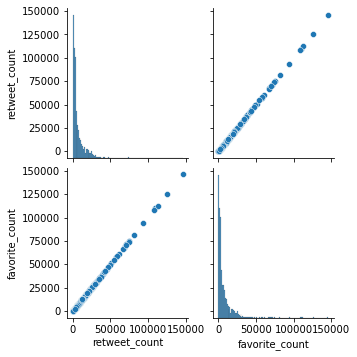

In [871]:
#Use seaborn pairplot to see if we can visually detect pairwise relationship.

import seaborn as sns
sns.pairplot(df_rate[['retweet_count', 'favorite_count']]);

In [872]:
#Perform a regression on the dog_category with rating as a response.
df_rate = df_master[['rating', 'dog_category']].copy()
df_dummies = pd.get_dummies(df_rate.dog_category)
df_rate[list(df_dummies.columns)] = df_dummies
df_rate['intercept'] = 1

logm = sm.OLS(df_rate.rating, df_rate[['intercept', 'doggo', 'floofer', 'pupper', 'puppo']])

print(logm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     7.094
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.16e-05
Time:                        18:15:24   Log-Likelihood:                 365.37
No. Observations:                1681   AIC:                            -720.7
Df Residuals:                    1676   BIC:                            -693.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0774      0.005    208.285      0.0

In [873]:
#Check top dog breeds (by rating) with simple sorted list
df_rate = df_master[['rating', 'breed_prediction']]
breed_counts = df_rate.breed_prediction.value_counts()
breed_counts = list(breed_counts[(breed_counts > 10)].index)
df_rate = df_rate.query(f'breed_prediction in {breed_counts}')
df_rate

df_rate.groupby('breed_prediction').mean().sort_values(by='rating', ascending=False)

,rating
breed_prediction,
Samoyed,1.173171
golden_retriever,1.166752
kuvasz,1.163158
Great_Pyrenees,1.146667
chow,1.141667
Pembroke,1.141053
Eskimo_dog,1.140909
cocker_spaniel,1.133333
kelpie,1.130769


### Insights:
1. Favorite_count and retweet_count have a positive correlation for the response rating. 

2. Doggos and puppos have a strong probability of a positive correlation for response rating.

3. The top 5 rated dogs (as detected) were Pomeranian, Samoyed, golden_retriever, kuvasz, great pyrenees, in that order.


### Visualization

Text(0.5, 1.0, 'Dog post source device breakdown')

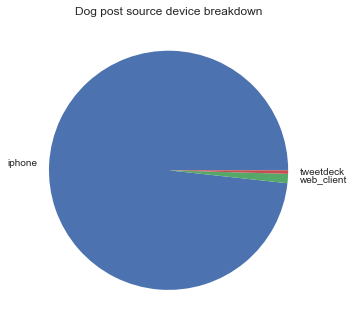

In [889]:
#A pie graph of the source device breakdown:
devices = df_master.source_device.value_counts()
plt.pie(devices.values, labels=list(devices.index))
plt.title('Dog post source device breakdown')


Text(0.5, 1.0, 'Dog ratings by favorite counts')

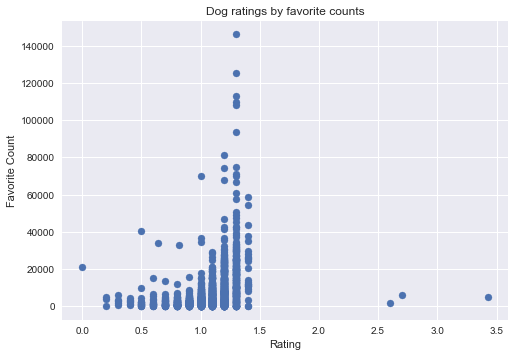

In [879]:
#A scatter of the favorited_counts by rating:
plt.style.use('seaborn')
plt.scatter(df_master.rating, df_master.favorite_count)
plt.xlabel('Rating')
plt.ylabel('Favorite Count')
plt.title('Dog ratings by favorite counts')

